# STEP 01. A & notA 구분

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import gc
import math
import random
import pickle
import pandas as pd
import numpy as np
import multiprocessing
from tqdm.auto import tqdm

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, sampler

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import shap
import catboost
from catboost import Pool, cv

pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv("./data/train.csv").drop(columns=['father', 'mother', 'gender'])
train.drop_duplicates(subset=train.columns.tolist()[5:20], inplace=True, ignore_index=True)
test = pd.read_csv("./data/test.csv").drop(columns=['father', 'mother', 'gender'])

train.iloc[:, 1:-1] = train.iloc[:, 1:-1].astype('category')
test.iloc[:, 1:] = test.iloc[:, 1:].astype('category')

answer = np.zeros(len(test)) - 1

train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      248 non-null    object  
 1   trait   248 non-null    category
 2   SNP_01  248 non-null    category
 3   SNP_02  248 non-null    category
 4   SNP_03  248 non-null    category
 5   SNP_04  248 non-null    category
 6   SNP_05  248 non-null    category
 7   SNP_06  248 non-null    category
 8   SNP_07  248 non-null    category
 9   SNP_08  248 non-null    category
 10  SNP_09  248 non-null    category
 11  SNP_10  248 non-null    category
 12  SNP_11  248 non-null    category
 13  SNP_12  248 non-null    category
 14  SNP_13  248 non-null    category
 15  SNP_14  248 non-null    category
 16  SNP_15  248 non-null    category
 17  class   248 non-null    object  
dtypes: category(16), object(2)
memory usage: 9.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data colu

(None, None)

In [3]:
def catgbmc(inputX, inputY, validX, validY, params) :  
    var_categ = inputX.columns.tolist()
    model = CatBoostClassifier(
        cat_features=var_categ,
        **params,
        task_type='GPU',
        devices='0',
        )
  
    model.fit(
        inputX, inputY,
        eval_set=(inputX, inputY)
        );     

    pred = model.predict(validX)
    score = f1_score(validY, pred, average='macro')
    print(score)
    
    return model

In [4]:
def catcv(inputX, inputY, params, cv_count) :  
    
    var_categ = inputX.columns.tolist()
    
    cv_dataset = Pool(data=inputX,
                      label=inputY,
                      cat_features=var_categ)
    
    scores = cv(cv_dataset,
                params,
                fold_count=cv_count,
                stratified=True,
                plot=True)

In [5]:
params = {'iterations':30,
          'learning_rate':0.03,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [6]:
X, y = train.drop(columns=['id', 'class']), (train['class'].values == 'A').astype('int')
X_test = test.drop(columns=['id']).copy()

catcv(X, y, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1
bestIteration = 0

Training on fold [1/5]

bestTest = 1
bestIteration = 0

Training on fold [2/5]

bestTest = 1
bestIteration = 0

Training on fold [3/5]

bestTest = 1
bestIteration = 0

Training on fold [4/5]

bestTest = 1
bestIteration = 0



In [7]:
params = {'iterations':10,
          'learning_rate':0.05,
          'l2_leaf_reg' : 10,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

modelA = catgbmc(X, y, X, y, params)

1.0


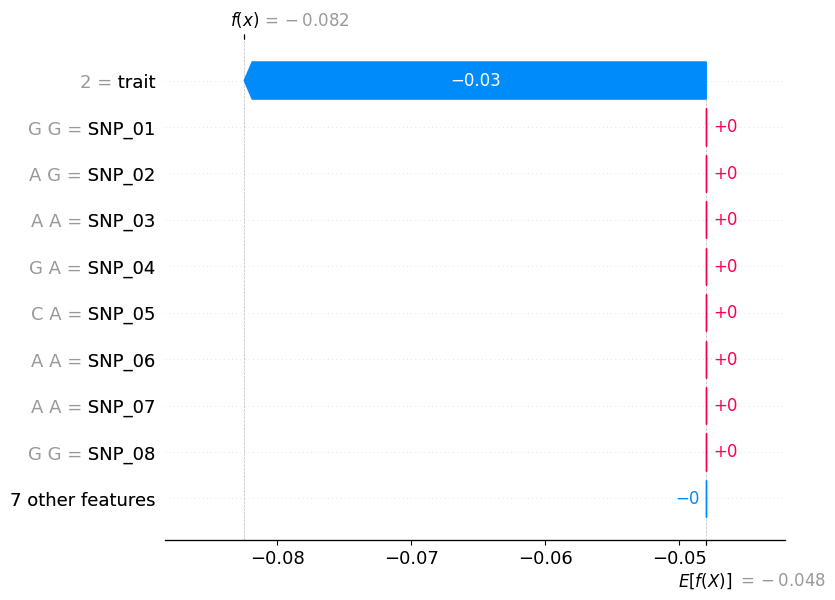

In [8]:
explainer = shap.Explainer(modelA)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [9]:
pd.DataFrame(data=modelA.get_feature_importance(), index=modelA.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
trait,100.0
SNP_01,0.0
SNP_02,0.0
SNP_03,0.0
SNP_04,0.0
SNP_05,0.0
SNP_06,0.0
SNP_07,0.0
SNP_08,0.0
SNP_09,0.0


In [10]:
predA = modelA.predict(X_test)
predA

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [12]:
predA.sum()

51

In [11]:
answer += predA
answer

array([ 0., -1., -1., -1.,  0., -1., -1., -1.,  0.,  0., -1., -1., -1.,
        0., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0., -1., -1.,
       -1.,  0.,  0., -1.,  0.,  0., -1., -1.,  0., -1., -1., -1., -1.,
       -1.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0., -1.,
        0., -1., -1., -1., -1.,  0., -1., -1.,  0., -1., -1., -1., -1.,
        0., -1.,  0.,  0., -1., -1., -1.,  0.,  0., -1., -1., -1., -1.,
       -1., -1., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0., -1.,
       -1., -1., -1., -1., -1.,  0., -1.,  0., -1.,  0., -1., -1., -1.,
        0.,  0., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,
       -1., -1., -1.,  0., -1., -1., -1., -1., -1., -1., -1.,  0., -1.,
        0.,  0., -1., -1., -1., -1.,  0.,  0., -1.,  0.,  0.,  0., -1.,
       -1., -1., -1.,  0., -1., -1.,  0.,  0., -1.,  0., -1., -1.,  0.,
        0., -1., -1.,  0., -1., -1., -1., -1.,  0.,  0., -1., -1., -1.,
        0., -1., -1., -1., -1., -1.])

# STEP 2. B & not B, C & notC

In [13]:
# A를 구분하는데에만 사용되는 trait 함수 제거

train2 = train.drop(columns=['trait'])
test2 = test.drop(columns=['trait'])

train2 = train2[train2['class']!='A'].copy().reset_index(drop=True)

train2

,id,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,G G,A G,A A,G A,C A,A A,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,A G,A G,C A,A A,A A,A G,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,G G,G G,A A,G A,C C,G G,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_004,G G,G G,C C,A A,C C,A A,A A,A A,A A,G G,A A,A A,A G,A A,G A,C
4,TRAIN_005,G G,G G,C A,A A,C C,A A,A A,G A,A A,G G,A A,A A,A A,A A,A A,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,TRAIN_254,A G,A G,C A,A A,C A,A G,A A,G G,A A,G G,A G,G A,A G,A A,A A,B
184,TRAIN_255,A G,G G,C A,G A,C C,A G,G A,G G,A A,G G,G G,A A,A A,A A,G A,B
185,TRAIN_256,G G,G G,C A,G A,C C,A G,A A,G G,A A,G G,A G,G A,A A,A A,A A,B
186,TRAIN_257,A G,A G,A A,G A,C C,A G,A A,G A,A A,G G,A G,G A,A A,A A,A A,B


In [14]:
test2

,id,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,TEST_000,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,TEST_001,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,TEST_002,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,TEST_003,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,TEST_004,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,TEST_170,A G,G G,C C,A A,C A,A G,A A,G G,A A,G G,G G,A A,A A,A A,G A
171,TEST_171,G G,A A,A A,A A,C A,A G,A A,A A,A A,A G,A A,A A,A G,A A,G A
172,TEST_172,G G,A A,A A,A A,C A,A G,A A,A A,A A,G G,A G,A A,A G,A A,G G
173,TEST_173,A G,G G,C A,G A,C C,G G,A A,G A,A A,G G,A G,A A,A A,A A,A A


In [15]:
params = {'iterations':300,
          'learning_rate':0.03,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [16]:
X, y = train2.drop(columns=['id', 'class']), (train2['class'].values == 'B').astype('int')
X_test = test2.drop(columns=['id']).copy()

catcv(X, y, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9777777778
bestIteration = 261

Training on fold [1/5]

bestTest = 0.9565217391
bestIteration = 57

Training on fold [2/5]

bestTest = 0.9333333333
bestIteration = 133

Training on fold [3/5]

bestTest = 0.9090909091
bestIteration = 40

Training on fold [4/5]

bestTest = 0.9565217391
bestIteration = 20



In [17]:
def catgbmc(inputX, inputY, validX, validY, params) :  
    var_categ = inputX.columns.tolist()
    model = CatBoostClassifier(
        cat_features=var_categ,
        **params,
        task_type='GPU',
        devices='1',
        )
  
    model.fit(
        inputX, inputY,
        eval_set=(inputX, inputY)
        );     

    pred = model.predict(validX)
    score = f1_score(validY, pred, average='macro')
    
    return score

In [18]:
from sklearn.model_selection import train_test_split

high = 0.9
for i in tqdm(range(2000)) :
    params = {'iterations':100,
          'learning_rate':0.3,
          'auto_class_weights' : 'Balanced',
          'verbose':0,
          'random_seed':i}
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=i, shuffle=True)
    score = catgbmc(X_train, y_train, X_valid, y_valid, params)   
    
    if score > high :
        high = score
        print(f"Random Seed : {i}, Score is {score}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Random Seed : 0, Score is 0.9640151515151516
Random Seed : 20, Score is 0.9646401985111662
Random Seed : 59, Score is 0.9821036106750393
Random Seed : 139, Score is 0.9822595704948646


In [ ]:
from sklearn.model_selection import train_test_split

high = 0.9
for i in tqdm(range(2000)) :
    params = {'iterations':100,
          'learning_rate':0.3,
          'auto_class_weights' : 'Balanced',
          'verbose':0,
          'random_seed':i}
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, stratify=y, random_state=i, shuffle=True)
    score = catgbmc(X_train, y_train, X_valid, y_valid, params)   
    
    if score > high :
        high = score
        print(f"Random Seed : {i}, Score is {score}")

In [69]:
train2 = train.drop(columns=['trait'])
test2 = test.drop(columns=['trait'])

X0, y0 = train2[train2['class']!='A'].copy().reset_index(drop=True).drop(columns=['id', 'class']), (train2[train2['class']!='A'].copy().reset_index(drop=True)['class'].values == 'B').astype('int')

# B & notB 파생변수 있는 버전 성능 확인
X, y = train2.drop(columns=['id', 'class']), (train2['class'].values)
X_test = test2.drop(columns=['id']).copy()


strategy1 = {'A':1000, 'B':1000, 'C':1000}
strategy2 = {'A':1000, 'B':1000, 'C':1000}

smote1 = SMOTEN(sampling_strategy=strategy1, k_neighbors=13, random_state=0)
smote2 = RandomOverSampler(sampling_strategy=strategy2, random_state=0)

X1, y1 = smote1.fit_resample(X, y)
X2, y2 = smote2.fit_resample(X, y)

df1 = X1.copy()
df2 = X2.copy()
df1['class'] = y1
df2['class'] = y2

df1 = df1[df1['class'] != 'A'].copy().reset_index(drop=True)
df2 = df2[df2['class'] != 'A'].copy().reset_index(drop=True)

X1, y1 = df1.drop(columns='class'), (df1['class'].values=='B').astype('int')
X2, y2 = df2.drop(columns='class'), (df2['class'].values=='B').astype('int')

In [70]:
catcv(X1, y1, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1
bestIteration = 35

Training on fold [1/5]

bestTest = 0.9924433249
bestIteration = 30

Training on fold [2/5]

bestTest = 0.9974937343
bestIteration = 77

Training on fold [3/5]

bestTest = 0.9950248756
bestIteration = 6

Training on fold [4/5]

bestTest = 0.9851485149
bestIteration = 8



In [71]:
catcv(X2, y2, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1
bestIteration = 43

Training on fold [1/5]

bestTest = 1
bestIteration = 35

Training on fold [2/5]

bestTest = 1
bestIteration = 41

Training on fold [3/5]

bestTest = 1
bestIteration = 14

Training on fold [4/5]

bestTest = 0.9900990099
bestIteration = 40



In [73]:
params = {'iterations':300,
          'learning_rate':0.3,
          'l2_leaf_reg' : 10,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

modelB1 = catgbmc(X1, y1, X0, y0, params)

1.0


In [74]:
params = {'iterations':300,
          'learning_rate':0.3,
          'l2_leaf_reg' : 10,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

modelB2 = catgbmc(X2, y2, X0, y0, params)

1.0


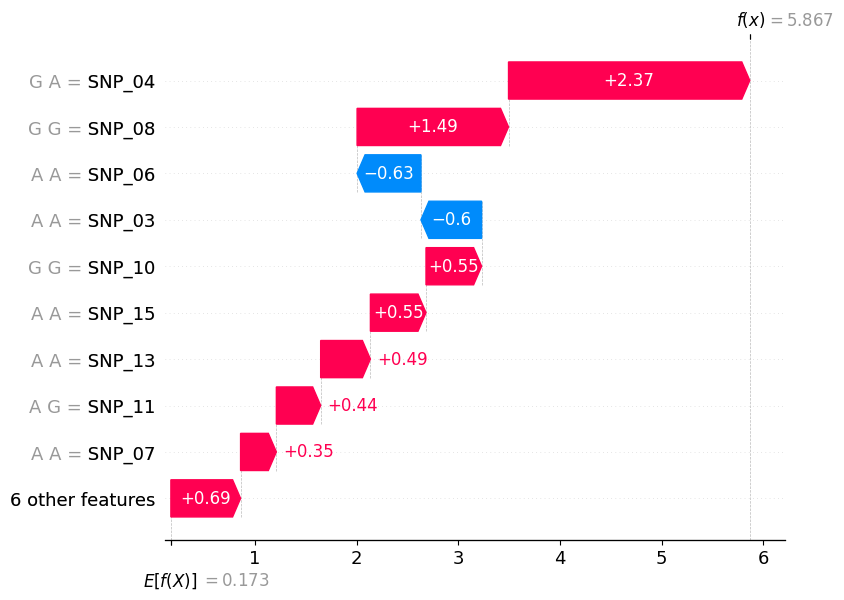

In [75]:
explainer = shap.Explainer(modelB1)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [76]:
pd.DataFrame(data=modelB1.get_feature_importance(), index=modelB1.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
SNP_10,17.190353
SNP_05,15.550404
SNP_11,13.110929
SNP_02,12.530140
SNP_08,9.673153
SNP_04,9.584612
SNP_07,7.771131
SNP_15,4.153115
SNP_14,2.526014
SNP_13,2.422273


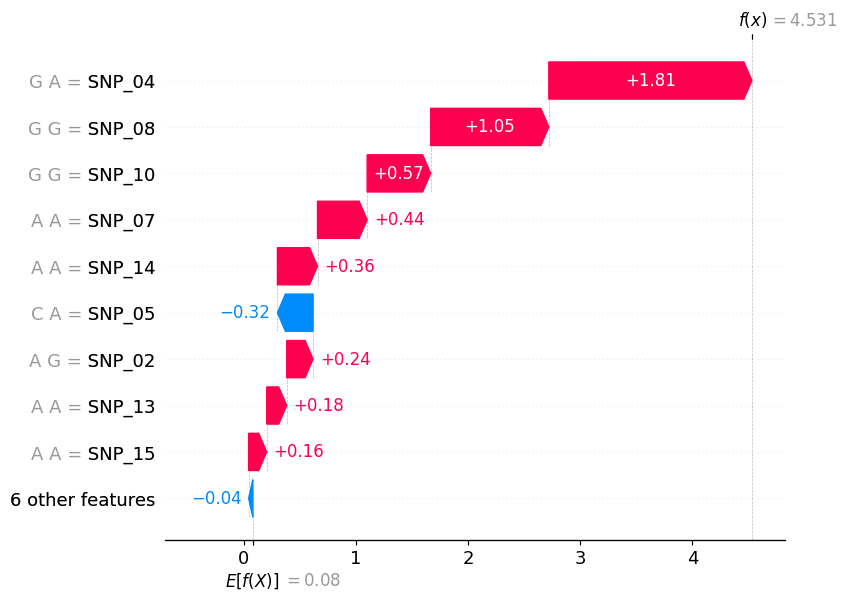

In [77]:
explainer = shap.Explainer(modelB2)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [78]:
pd.DataFrame(data=modelB2.get_feature_importance(), index=modelB2.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
SNP_05,20.410582
SNP_04,17.513989
SNP_08,12.423916
SNP_10,11.741826
SNP_14,7.919103
SNP_07,7.550226
SNP_15,7.381479
SNP_02,4.516049
SNP_12,2.888758
SNP_11,2.832395


In [79]:
modelA.predict(test.drop(columns=['id']).copy())

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [80]:
modelB1.predict(X_test)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1])

In [81]:
modelB2.predict(X_test)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1])

In [82]:
df = pd.DataFrame()
df['predA'] = modelA.predict_proba(test.drop(columns=['id']).copy())[:,1]
df['predB1'] = modelB1.predict_proba(X_test)[:,1]
df['predB2'] = modelB2.predict_proba(X_test)[:,1]
df['high1'] = pd.read_csv("./submit_high1.csv")['class']
df['high2'] = pd.read_csv("./submit_high2.csv")['class']
df

,predA,predB1,predB2,high1,high2
0,0.589040,0.141174,0.034706,A,A
1,0.378778,0.992505,0.977415,B,B
2,0.378778,0.001626,0.012973,C,C
3,0.378778,0.829081,0.876052,C,C
4,0.589040,0.103483,0.109870,A,A
...,...,...,...,...,...
170,0.378778,0.989463,0.903512,B,B
171,0.378778,0.001489,0.004928,C,C
172,0.378778,0.002250,0.214528,C,C
173,0.378778,0.999466,0.995721,B,B


In [83]:
df[(df.predA >= 0.5) & ((df.predB1 >= 0.5) | (df.predB2 >= 0.5))]

,predA,predB1,predB2,high1,high2


In [84]:
df[((df.predB1 >= 0.5) & (df.predB2 < 0.5)) | ((df.predB1 < 0.5) & (df.predB2 >= 0.5))]

,predA,predB1,predB2,high1,high2
12,0.378778,0.603461,0.395163,B,C
25,0.378778,0.279944,0.855514,B,B
35,0.378778,0.407786,0.916699,B,B
111,0.378778,0.423884,0.686290,B,B
117,0.378778,0.083757,0.513531,C,C


In [85]:
submit = df.copy()
submit['predB3'] = submit[['predB1', 'predB2']].mean(axis=1)
submit['answer1'] = -1
submit['answer2'] = -1
submit['answer3'] = -1

submit.loc[submit.predA >= 0.5, ['answer1', 'answer2', 'answer3']] = 'A'
submit.loc[(submit.predA <0.5) & (submit.predB1 >= 0.5), 'answer1'] = 'B'
submit.loc[(submit.predA <0.5) & (submit.predB1 < 0.5), 'answer1'] = 'C'

submit.loc[(submit.predA <0.5) & (submit.predB2 >= 0.5), 'answer2'] = 'B'
submit.loc[(submit.predA <0.5) & (submit.predB2 < 0.5), 'answer2'] = 'C'

submit.loc[(submit.predA <0.5) & (submit.predB3 >= 0.5), 'answer3'] = 'B'
submit.loc[(submit.predA <0.5) & (submit.predB3 < 0.5), 'answer3'] = 'C'

submit

,predA,predB1,predB2,high1,high2,predB3,answer1,answer2,answer3
0,0.589040,0.141174,0.034706,A,A,0.087940,A,A,A
1,0.378778,0.992505,0.977415,B,B,0.984960,B,B,B
2,0.378778,0.001626,0.012973,C,C,0.007300,C,C,C
3,0.378778,0.829081,0.876052,C,C,0.852567,B,B,B
4,0.589040,0.103483,0.109870,A,A,0.106677,A,A,A
...,...,...,...,...,...,...,...,...,...
170,0.378778,0.989463,0.903512,B,B,0.946488,B,B,B
171,0.378778,0.001489,0.004928,C,C,0.003208,C,C,C
172,0.378778,0.002250,0.214528,C,C,0.108389,C,C,C
173,0.378778,0.999466,0.995721,B,B,0.997594,B,B,B


In [87]:
submit[(submit.high1 != submit.answer1) | (submit.high2 != submit.answer1)]

,predA,predB1,predB2,high1,high2,predB3,answer1,answer2,answer3
3,0.378778,0.829081,0.876052,C,C,0.852567,B,B,B
5,0.378778,0.828005,0.697483,C,C,0.762744,B,B,B
12,0.378778,0.603461,0.395163,B,C,0.499312,B,C,C
25,0.378778,0.279944,0.855514,B,B,0.567729,C,B,B
35,0.378778,0.407786,0.916699,B,B,0.662242,C,B,B
66,0.378778,0.480149,0.419443,B,B,0.449796,C,C,C
111,0.378778,0.423884,0.686290,B,B,0.555087,C,B,B
119,0.378778,0.504077,0.750114,C,C,0.627096,B,B,B
126,0.378778,0.100455,0.245594,B,C,0.173024,C,C,C


In [88]:
submit[(submit.high1 != submit.answer2) | (submit.high2 != submit.answer2)]

,predA,predB1,predB2,high1,high2,predB3,answer1,answer2,answer3
3,0.378778,0.829081,0.876052,C,C,0.852567,B,B,B
5,0.378778,0.828005,0.697483,C,C,0.762744,B,B,B
12,0.378778,0.603461,0.395163,B,C,0.499312,B,C,C
66,0.378778,0.480149,0.419443,B,B,0.449796,C,C,C
117,0.378778,0.083757,0.513531,C,C,0.298644,C,B,C
119,0.378778,0.504077,0.750114,C,C,0.627096,B,B,B
126,0.378778,0.100455,0.245594,B,C,0.173024,C,C,C


In [89]:
submit[(submit.high1 != submit.answer3) | (submit.high2 != submit.answer3)]

,predA,predB1,predB2,high1,high2,predB3,answer1,answer2,answer3
3,0.378778,0.829081,0.876052,C,C,0.852567,B,B,B
5,0.378778,0.828005,0.697483,C,C,0.762744,B,B,B
12,0.378778,0.603461,0.395163,B,C,0.499312,B,C,C
66,0.378778,0.480149,0.419443,B,B,0.449796,C,C,C
119,0.378778,0.504077,0.750114,C,C,0.627096,B,B,B
126,0.378778,0.100455,0.245594,B,C,0.173024,C,C,C


In [91]:
df = pd.read_csv("submit_high1.csv")
df['class'] = submit['answer1']
df.to_csv("submit_last1.csv", index=False)
df['class'].value_counts()

B    82
A    51
C    42
Name: class, dtype: int64

In [93]:
df = pd.read_csv("submit_high1.csv")
df['class'] = submit['answer2']
df.to_csv("submit_last2.csv", index=False)
df['class'].value_counts()

B    85
A    51
C    39
Name: class, dtype: int64

In [94]:
df = pd.read_csv("submit_high1.csv")
df['class'] = submit['answer3']
df.to_csv("submit_last3.csv", index=False)
df['class'].value_counts()

B    84
A    51
C    40
Name: class, dtype: int64